# Two Step Forecasting for weather and kWh delivered (using CNN)

In this model, I would be implementing a two-step forecast that would first predict the weather for a time in the future and then use the predicted weather data as an input for the kWh Delivered forecasting for the model

In [3]:
# Import necessary packages

In [20]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input

In [5]:
# Load the weather data from the weather data folder

In [21]:
folder_path = './caltech_weather_data'
data_frames = []

# Function to safely extract data from JSON
def extract_hourly_data(data):
    historical_data = data.get('historical', {})
    for date, details in historical_data.items():
        hourly_data = details.get('hourly', [])
        for hour_data in hourly_data:
            hour_data['date'] = date
            data_frames.append(hour_data)

for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        file_path = os.path.join(folder_path, file_name)
        try:
            with open(file_path) as file:
                data = json.load(file)
                extract_hourly_data(data)
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Error processing file {file_name}: {e}")

df = pd.DataFrame(data_frames)
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

weather_df = pd.DataFrame(data_frames)
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df.sort_values('date', inplace=True)

# Select relevant features
weather_features = ['temperature', 'wind_speed', 'pressure', 'humidity', 'precip','uv_index']
weather_df = weather_df[weather_features + ['date']]

# Aggregate weather data by day (since kWh data is monthly, daily aggregation should be sufficient)
weather_daily_df = weather_df.groupby('date').mean().reset_index()

weather_daily_df.head()


,date,temperature,wind_speed,pressure,humidity,precip,uv_index
0,2018-04-01,15.750,7.250,1012.250,55.250,0.0,3.000
1,2018-04-02,14.250,10.250,1010.500,65.750,0.0,2.625
2,2018-04-03,15.750,6.875,1014.125,64.875,0.0,3.000
3,2018-04-04,15.750,7.750,1016.125,65.625,0.0,3.000
4,2018-04-05,15.875,8.000,1015.750,62.125,0.0,3.000


In [ ]:
# Select relevant features

In [22]:
features = ['temperature', 'wind_speed', 'pressure', 'humidity', 'cloudcover', 'precip', 'uv_index']
df = df[features + ['date']]

In [ ]:
# Normalize the data and split into training and testing sets

In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features])

# Create sequences for CNN
sequence_length = 30
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i])

X, y = np.array(X), np.array(y)

# Split data into training and testing sets
train_size = int(X.shape[0] * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Build a CNN using the data from the model

In [24]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(features)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

Epoch 1/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0401
Epoch 2/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0257
Epoch 3/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0241
Epoch 4/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0229
Epoch 5/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0221
Epoch 6/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0216
Epoch 7/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0211
Epoch 8/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0207
Epoch 9/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0207
Epoch 10/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0204
Epoch 11/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0199
Epoch 12/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0199
Epoch 13/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0197
Epoch 14/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0195
Epoch 15/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lo

In [ ]:
# Evaluate the model and check for accuracy

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Temperature - Mean Absolute Error: 2.780259494781494
Temperature - Mean Squared Error: 11.708609567972728
Wind_speed - Mean Absolute Error: 3.2548801297611663
Wind_speed - Mean Squared Error: 16.753075974902643
Pressure - Mean Absolute Error: 1.8011622450086806
Pressure - Mean Squared Error: 5.605985250601338
Humidity - Mean Absolute Error: 11.24134341928694
Humidity - Mean Squared Error: 197.24917078607257
Cloudcover - Mean Absolute Error: 20.03313284854094
Cloudcover - Mean Squared Error: 747.6985800382878
Precip - Mean Absolute Error: 0.13991008453249298
Precip - Mean Squared Error: 0.21683878084465133
Uv_index - Mean Absolute Error: 1.3210710800025198
Uv_index - Mean Squared Error: 2.5140766302870845


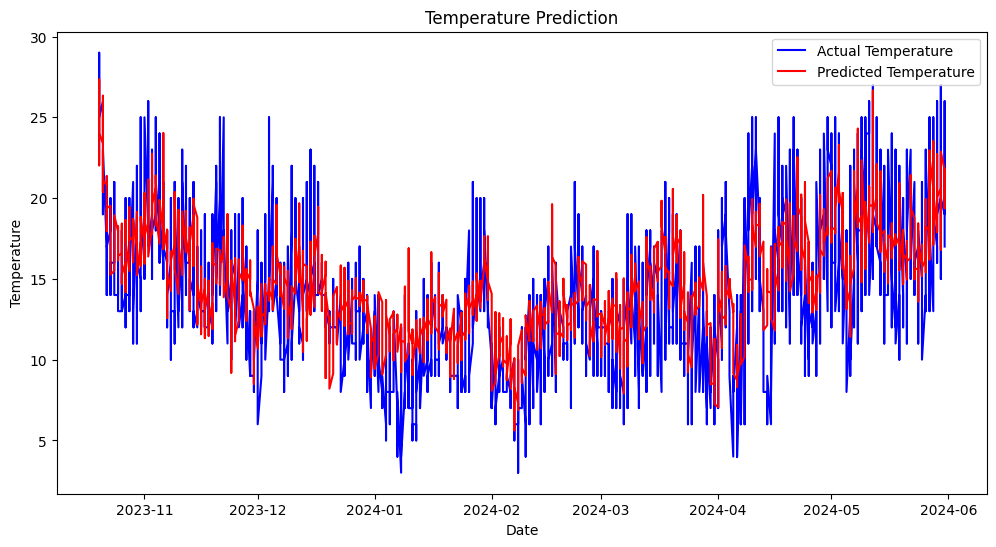

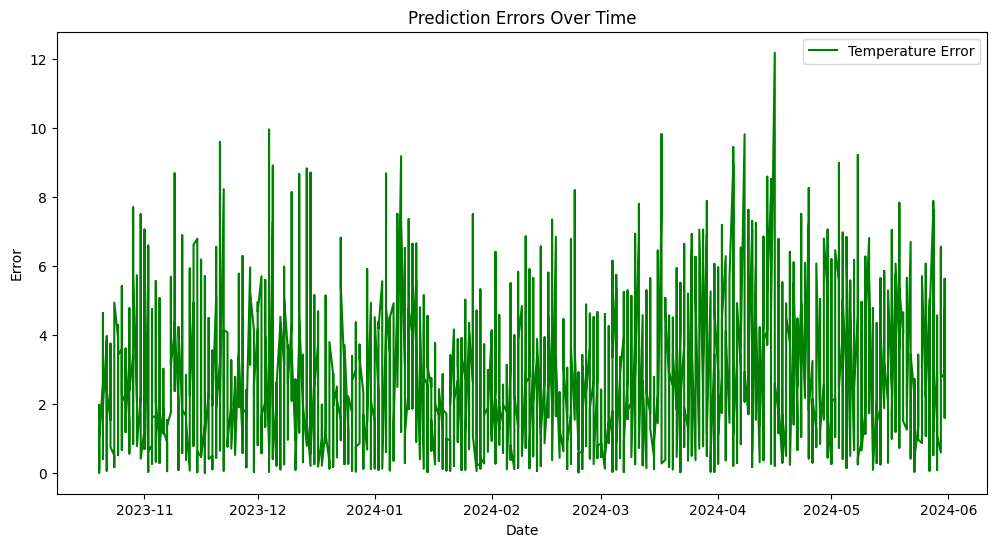

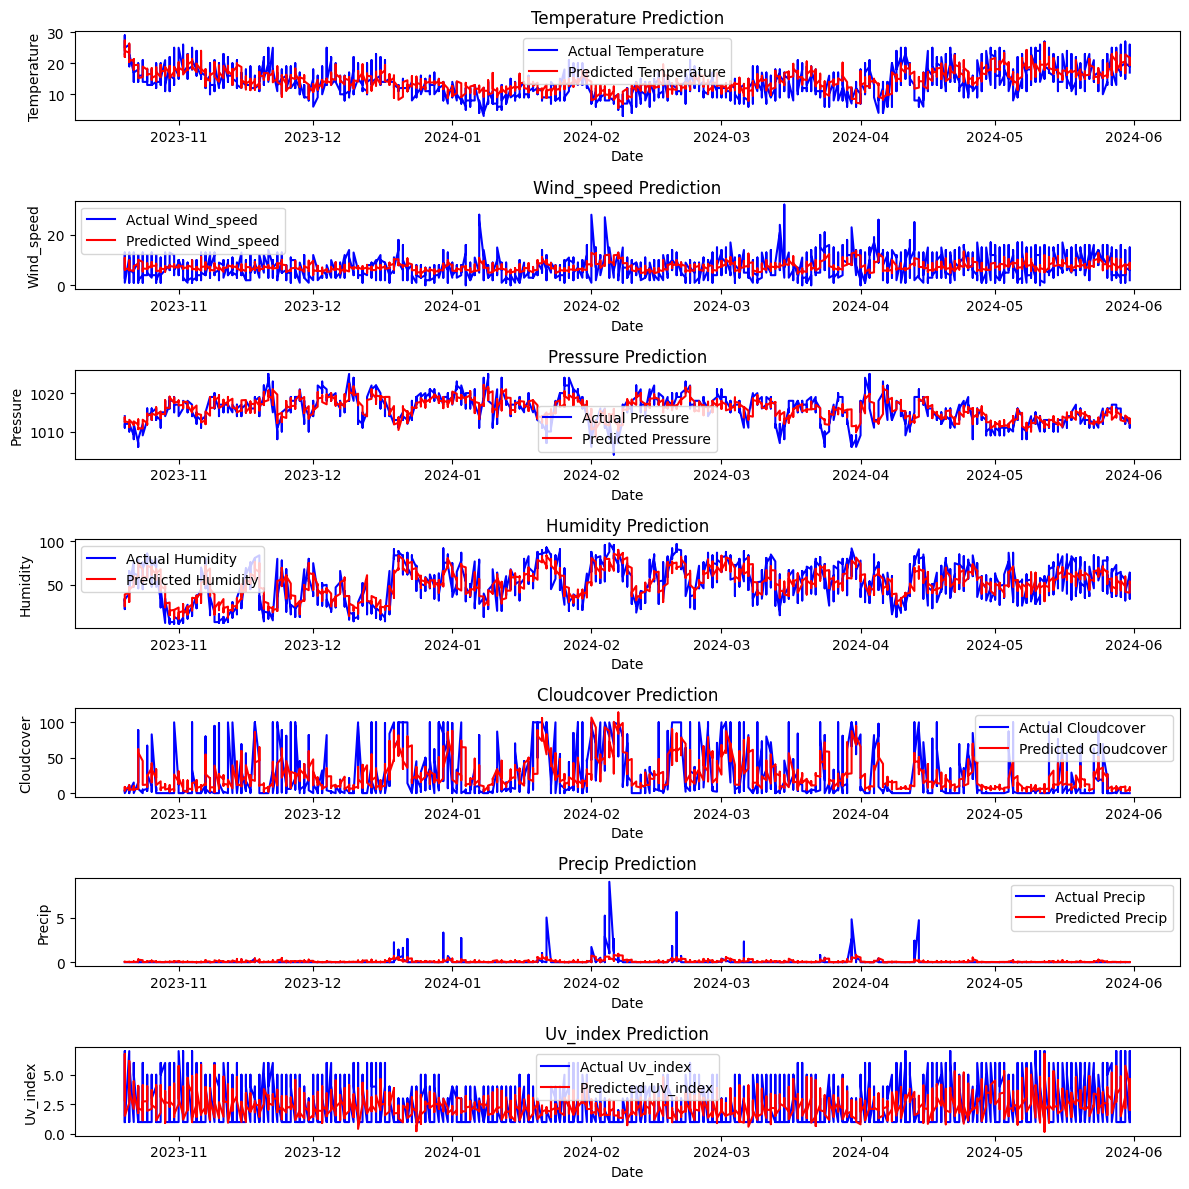

In [25]:
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

# Evaluate the model for each feature
mae_per_feature = []
mse_per_feature = []

for i, feature in enumerate(features):
    mae = mean_absolute_error(y_test_inverse[:, i], y_pred_inverse[:, i])
    mse = mean_squared_error(y_test_inverse[:, i], y_pred_inverse[:, i])
    mae_per_feature.append(mae)
    mse_per_feature.append(mse)
    print(f'{feature.capitalize()} - Mean Absolute Error: {mae}')
    print(f'{feature.capitalize()} - Mean Squared Error: {mse}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df['date'][train_size+sequence_length:], y_test_inverse[:, 0], color='blue', label='Actual Temperature')
plt.plot(df['date'][train_size+sequence_length:], y_pred_inverse[:, 0], color='red', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Plot the errors over time
errors = np.abs(y_test_inverse - y_pred_inverse)
plt.figure(figsize=(12, 6))
plt.plot(df['date'][train_size+sequence_length:], errors[:, 0], color='green', label='Temperature Error')
plt.title('Prediction Errors Over Time')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.show()

# Plot Actual vs Predicted for all features
plt.figure(figsize=(12, 12))
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i+1)
    plt.plot(df['date'][train_size+sequence_length:], y_test_inverse[:, i], color='blue', label=f'Actual {feature.capitalize()}')
    plt.plot(df['date'][train_size+sequence_length:], y_pred_inverse[:, i], color='red', label=f'Predicted {feature.capitalize()}')
    plt.title(f'{feature.capitalize()} Prediction')
    plt.xlabel('Date')
    plt.ylabel(feature.capitalize())
    plt.legend()

plt.tight_layout()
plt.show()

In [26]:
display(HTML("""<h2>Second step</h2> <p>Using the forecasted weather data to predict future kWh delivered by electric vehicle charging stations</p>"""))

In [ ]:
# Load and preprocess the EV charging station data

In [28]:
stations_folder_path = './caltech_stations_data'
stations_data_frames = []

for file_name in os.listdir(stations_folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(stations_folder_path, file_name)
        try:
            station_df = pd.read_csv(file_path)
            stations_data_frames.append(station_df)
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

ev_data = pd.concat(stations_data_frames, ignore_index=True)
ev_data['date'] = pd.to_datetime(ev_data['month'], format='%Y-%m')
ev_data.drop(columns=['month'], inplace=True)

In [ ]:
# Merge the weather data with the EV charging station data

In [29]:
merged_df = pd.merge(ev_data, weather_daily_df, on='date', how='left')

In [ ]:
# Fill missing values (if any) with forward fill method

In [30]:
merged_df.ffill(inplace=True)

In [ ]:
# Perform feature engineering
# Normalize the data

In [31]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_df[weather_features + ['kWhDelivered']])

# Create sequences for CNN
sequence_length = 30
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, -1])  # kWhDelivered is the target variable

X, y = np.array(X), np.array(y)

# Split data into training and testing sets
train_size = int(X.shape[0] * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the CNN model
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values
y_test_inverse = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], len(weather_features))), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_inverse = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], len(weather_features))), y_pred), axis=1))[:, -1]

# Evaluate the model
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f'Mean Absolute error', mae)
print(f'Mean Squared error', mse)

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1289  
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0429 
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0395 
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0277 
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0321 
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0300 
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0257 
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0259 
Epoch 9/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202 
Epoch 10/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0225 
Epoch 11/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0238 
Epoch 12/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0247 
Epoch 13/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0208 
Epoch 14/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222 
Epoch 15/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 
Epo

In [32]:
#Plot the relationships

Length of X_test: 0
Length of y_test_inverse: 63
Length of y_pred_inverse: 63
Length of date range: 0


ValueError: x and y must have same first dimension, but have shapes (0,) and (63,)

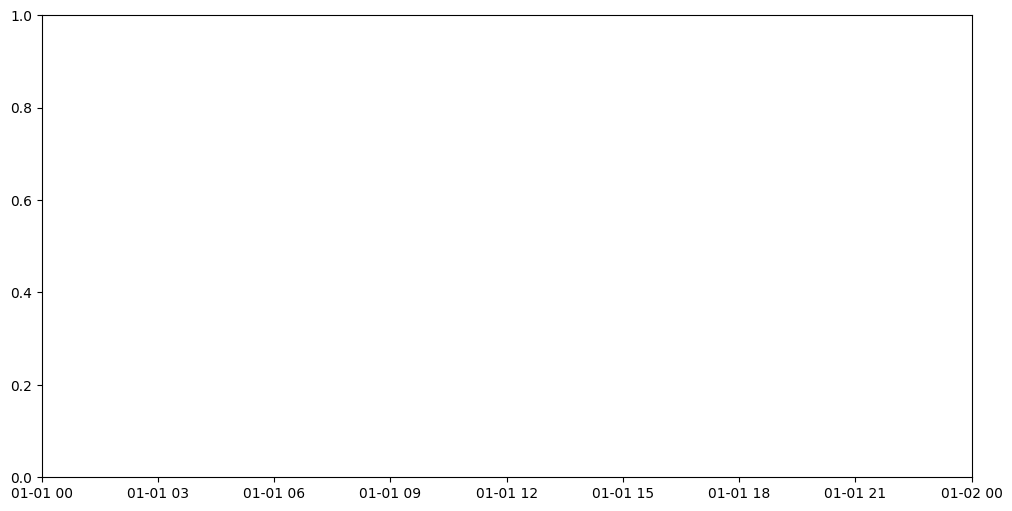

In [36]:
# Check the lengths of the data arrays
print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_test_inverse: {len(y_test_inverse)}")
print(f"Length of y_pred_inverse: {len(y_pred_inverse)}")
print(f"Length of date range: {len(merged_df['date'][train_size+sequence_length:])}")

# Ensure that dates match the length of y_test_inverse
dates = merged_df['date'][train_size+sequence_length:train_size+sequence_length+len(y_test_inverse)]

plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_inverse, color='blue', label='Actual kWh Delivered')
plt.plot(dates, y_pred_inverse, color='red', label='Predicted kWh Delivered')
plt.title('Overall kWh Delivered Prediction')
plt.xlabel('Date')
plt.ylabel('kWh Delivered')
plt.legend()
plt.show()

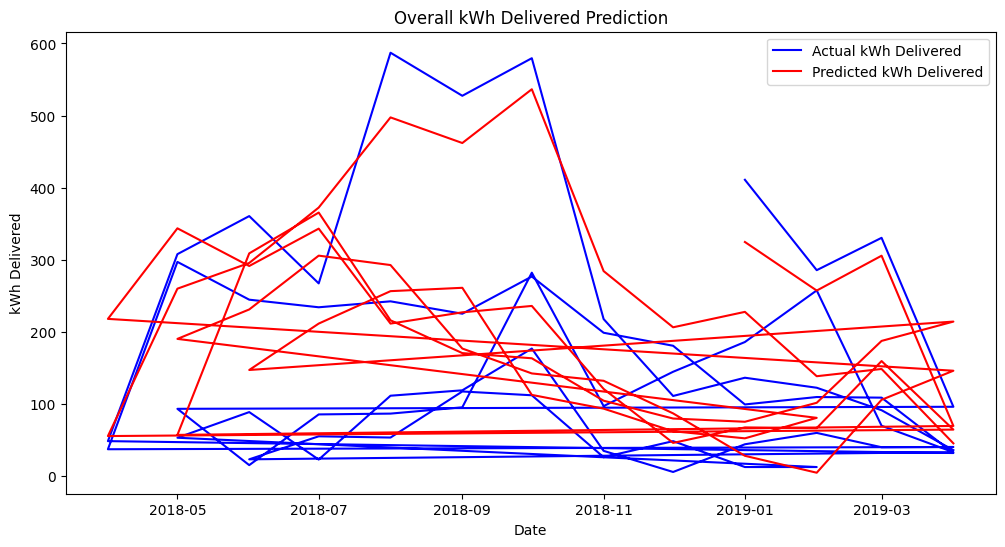

IndexError: tuple index out of range

In [33]:
# Plot Actual vs Predicted kWh Delivered for each station
unique_station_ids = ev_data['stationID'].unique()

for station_id in unique_station_ids:
    station_data = ev_data[ev_data['stationID'] == station_id]

    # Merge the weather data with the station-specific data
    merged_df = pd.merge(station_data, weather_daily_df, on='date', how='left')
    merged_df.ffill(inplace=True)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(merged_df[weather_features + ['kWhDelivered']])

    # Create sequences for CNN
    X = []
    y = []

    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i, -1])  # kWhDelivered is the target variable

    X, y = np.array(X), np.array(y)

    # Split data into training and testing sets
    train_size = int(X.shape[0] * 0.9)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build and train the CNN model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse scale the predictions and actual values
    y_test_inverse = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], len(weather_features))), y_test.reshape(-1, 1)), axis=1))[:, -1]
    y_pred_inverse = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], len(weather_features))), y_pred), axis=1))[:, -1]

    # Evaluate the model
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
    mse = mean_squared_error(y_test_inverse, y_pred_inverse)
    print(f'Station ID: {station_id} - Mean Absolute Error: {mae}')
    print(f'Station ID: {station_id} - Mean Squared Error: {mse}')

    # Plot the results for the current station
    plt.figure(figsize=(12, 6))
    plt.plot(merged_df['date'][train_size+sequence_length:], y_test_inverse, color='blue', label='Actual kWh Delivered')
    plt.plot(merged_df['date'][train_size+sequence_length:], y_pred_inverse, color='red', label='Predicted kWh Delivered')
    plt.title(f'Station ID: {station_id} - kWh Delivered Prediction')
    plt.xlabel('Date')
    plt.ylabel('kWh Delivered')
    plt.legend()
    plt.show()
